<a href="https://colab.research.google.com/github/thamadziripi/isolation-forest-ipqs-api/blob/main/fraud_detection_using_isolation_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection Using Isolation Forest and IPQualityScore API

# Project summary

This project demonstrates the detection of potentially fraudulent transactions using the **Isolation Forest** algorithm, augmented with data from the **IPQualityScore** API. The aim is to build a system that identifies anomalous transactions by leveraging a combination of machine learning and external risk factors, such as fraud scores and user activity.


This project integrates the **Isolation Forest** algorithm with the **IPQualityScore** API to build an efficient fraud detection framework. By combining unsupervised machine learning with external risk data, this notebook demonstrates a robust approach to identifying potentially fraudulent transactions in real-time.

This notebook serves as a practical demonstration of how machine learning models can be utilised to enhance fraud detection in transaction datasets, making it a valuable resource for financial and e-commerce fraud prevention applications.

## Key Components:

### Data Sourcing
The project utilises transaction data sourced from the IPQualityScore API, which provides insights into the likelihood of fraud based on various features, including:
- **Fraud score**: A numeric risk score (0-100) indicating the probability of fraudulent activity.
- **Valid billing and shipping address**: Boolean indicators showing the legitimacy of address details.
- **User activity**: Categorical data measuring the frequency of legitimate user behaviour (e.g., high, medium, low).
- **Leaked user data**: Indicates if the user's data has been exposed in known breaches.

### Data Preprocessing
The transaction data undergoes a series of preprocessing steps before being fed into the Isolation Forest model:
- **Categorical Encoding**: Categorical fields such as `user_activity` are encoded into numerical values.
- **Boolean Conversion**: Binary fields (e.g., address validity) are converted into integers (`1` for `True`, `0` for `False`).
- **Normalisation**: Numerical features are normalised to bring them onto a similar scale, optimising the performance of the model.

### Isolation Forest Model
An **Isolation Forest** is trained to detect anomalous transactions. This unsupervised algorithm isolates observations by randomly selecting features and split values, with anomalous transactions requiring fewer splits to be isolated. Key parameters include:
- **`contamination`**: Controls the expected proportion of anomalous transactions in the data.
- **`n_estimators`**: The number of trees in the forest, which impacts model accuracy and complexity.

### Fraud Detection Process
Once trained, the Isolation Forest identifies transactions as either normal (`1`) or anomalous (`-1`). Anomalous transactions are flagged for further inspection based on IPQualityScore's fraud score and other risk metrics. This hybrid approach combines rule-based insights with machine learning to enhance fraud detection.

### Model Tuning and Evaluation
The model parameters are fine-tuned to strike a balance between detecting actual fraud and minimising false positives. The system's performance is evaluated by comparing the flagged anomalies against IPQualityScore's fraud metrics, offering a data-driven approach to improving fraud detection accuracy.




# Code

## Project set-up

In [135]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import requests
import ipaddress
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time
import json
from google.colab import userdata

# Stored API key as a google colab secret (recommended)
API_KEY = userdata.get('IPQualitySocreAPIKey')
IP_TOKEN = userdata.get('IPInfoToken')

## Data preprocessing


### Creating training data using IPQS API

In [118]:
def get_ipqualityscore_data(api_key, ip_address: str) -> dict:
    """
    Function to lookup Payment & Transaction Fraud Prevention API for a given IP address.

    Args:
        api_key (str): Your API key for IPQualityScore.
        ip_address (str): The IP address to look up.

    Returns:
        dict: The fraud score and other relevant information, or error details.
    """
    url = f"https://ipqualityscore.com/api/json/ip/{api_key}/{ip_address}"

    try:
        response = requests.get(url)

        # Log the raw response for debugging purposes
        # print(f"Response for IP {ip_address}: {response.status_code}, Content: {response.text}")

        # Check if we have a valid response
        if response.status_code != 200:
            return {"error": f"Failed to fetch data: HTTP {response.status_code}"}

        data = response.json()

        # Check if 'fraud_score' is in the response to confirm valid data
        if 'fraud_score' not in data:
            return {"error": "Fraud score missing from response"}

        result = {
            "ip_address": ip_address,
            "fraud_score": data.get("fraud_score"),
            # "valid_billing_address": data.get("billing_address", {}).get("valid"),
            # "valid_shipping_address": data.get("shipping_address", {}).get("valid"),
            # "user_activity": data.get("user_activity"),
            # "leaked_user_data": data.get("leaked"),
            # "transaction_risk": data.get("transaction_risk"),
            "recent_abuse": data.get("recent_abuse"),
            "proxy": data.get("proxy"),
            "vpn": data.get("vpn"),
            "tor": data.get("tor")
            # "device_tracking": data.get("device_tracking"),
        }

        return result

    except Exception as e:
        return {"error": str(e)}

def iterate_ip_addresses(api_key: str, ip_addresses: list) -> pd.DataFrame:
    """
    A function that iterates through a list of IP addresses and returns a
    DataFrame of the results.

    Args:
        api_key (str): Your API key for IPQualityScore.
        ip_addresses (list): List of IP addresses to check.

    Returns:
        pd.DataFrame: A DataFrame containing fraud score and other details.
    """
    results = []

    for ip in ip_addresses:
        result = get_ipqualityscore_data(api_key, ip)
        results.append(result)

        # Introduce a small delay to prevent hitting rate limits
        time.sleep(1)  # Adjust the sleep time as necessary

    # Convert the list of results to a pandas DataFrame
    return pd.DataFrame(results)


### Querying legitimate and blocked IPv4

In [119]:
# Spamhaus DROP List URL
url = 'https://www.spamhaus.org/drop/drop.txt'

# Download and parse the blocklist
response = requests.get(url)

blocked_ip_list = []
if response.status_code == 200:
    blocklist = response.text.splitlines()

    # Extract the IPs from the blocklist
    for line in blocklist:
        if not line.startswith(';'):
            ip = line.split("/")[0]
            blocked_ip_list.append(ip)
else:
    print(f"Error downloading blocklist: {response.status_code}")

# Fetch data for the first 100 IP addresses
if blocked_ip_list:
    blocked_ip_data = iterate_ip_addresses(API_KEY, blocked_ip_list[:100])
else:
    print("No IPs found in the blocklist.")

Response for IP 1.10.16.0: 200, Content: {"success":true,"message":"Success","fraud_score":0,"country_code":"CN","region":"Guangdong","city":"Guangzhou","ISP":"ChinaNet Guangdong Province Network","ASN":4134,"organization":"ChinaNet Guangdong Province Network","is_crawler":false,"timezone":"Asia\/Shanghai","mobile":false,"host":"1.10.16.0","proxy":false,"vpn":false,"tor":false,"active_vpn":false,"active_tor":false,"recent_abuse":false,"bot_status":false,"connection_type":"Premium required.","abuse_velocity":"Premium required.","zip_code":"N\/A","latitude":23.12,"longitude":113.25,"request_id":"RkyMD2K4NV"}
Response for IP 1.19.0.0: 200, Content: {"success":true,"message":"Success","fraud_score":87,"country_code":"KR","region":"Jeollanam-do","city":"Naju","ISP":"Korea Internet Security Agency","ASN":0,"organization":"Korea Internet Security Agency","is_crawler":false,"timezone":"Asia\/Seoul","mobile":false,"host":"1.19.0.0","proxy":true,"vpn":true,"tor":false,"active_vpn":false,"active_

In [120]:
def fetch_aws_ip_ranges():
    aws_url = "https://ip-ranges.amazonaws.com/ip-ranges.json"
    try:
        response = requests.get(aws_url)
        response.raise_for_status()  # Raise an error for bad responses
        aws_data = response.json()
        return aws_data['prefixes']  # Return the list of prefixes
    except Exception as e:
        print(f"Error fetching AWS IP ranges: {e}")
        return []

aws_ip_ranges = fetch_aws_ip_ranges()

aws_legitimate_ips = []

for ip in aws_ip_ranges:
  ip_prefix = ip.get("ip_prefix").split("/")[0]
  aws_legitimate_ips.append(ip_prefix)

print(f"Total size of AWS IP ranges: {len(aws_legitimate_ips)}")

# Fetch data for the first 100 IP addresses
if blocked_ip_list:
    legitimate_ip_data = iterate_ip_addresses(API_KEY, aws_legitimate_ips[:100])
else:
    print("No IPs found in the blocklist.")

Total size of AWS IP ranges: 7892
Response for IP 3.4.12.4: 200, Content: {"success":true,"message":"Success","fraud_score":75,"country_code":"US","region":"Washington","city":"Seattle","ISP":"Amazon Technologies","ASN":14618,"organization":"Amazon Data Services NoVa","is_crawler":false,"timezone":"America\/Los_Angeles","mobile":false,"host":"3.4.12.4","proxy":true,"vpn":true,"tor":false,"active_vpn":false,"active_tor":false,"recent_abuse":false,"bot_status":false,"connection_type":"Premium required.","abuse_velocity":"Premium required.","zip_code":"N\/A","latitude":47.61,"longitude":-122.33,"request_id":"RkyVc6xKWO"}
Response for IP 3.5.140.0: 200, Content: {"success":true,"message":"Success","fraud_score":75,"country_code":"KR","region":"Incheon","city":"Incheon","ISP":"Amazon.com","ASN":16509,"organization":"Amazon.com","is_crawler":false,"timezone":"Asia\/Seoul","mobile":false,"host":"3.5.140.0","proxy":true,"vpn":true,"tor":false,"active_vpn":false,"active_tor":false,"recent_abuse

In [121]:
blocked_ip_data["on_blocked_list"] = True
blocked_ip_data.head()

,ip_address,fraud_score,recent_abuse,proxy,vpn,tor,on_blocked_list
0,1.10.16.0,0,False,False,False,False,True
1,1.19.0.0,87,True,True,True,False,True
2,1.32.128.0,0,False,False,False,False,True
3,2.56.192.0,87,True,True,True,False,True
4,2.57.122.0,100,True,True,True,False,True


In [122]:
legitimate_ip_data["on_blocked_list"] = False
legitimate_ip_data.head()

,ip_address,fraud_score,recent_abuse,proxy,vpn,tor,on_blocked_list
0,3.4.12.4,75,False,True,True,False,False
1,3.5.140.0,75,False,True,True,False,False
2,15.190.244.0,75,False,True,True,False,False
3,15.230.15.29,75,False,True,True,False,False
4,15.230.15.76,75,False,True,True,False,False


In [123]:
data = pd.concat([legitimate_ip_data, blocked_ip_data])
data.head()

,ip_address,fraud_score,recent_abuse,proxy,vpn,tor,on_blocked_list
0,3.4.12.4,75,False,True,True,False,False
1,3.5.140.0,75,False,True,True,False,False
2,15.190.244.0,75,False,True,True,False,False
3,15.230.15.29,75,False,True,True,False,False
4,15.230.15.76,75,False,True,True,False,False


### Data cleaning

In [129]:
# converting booleans to int
df = data.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

# Converting IP addresses to int
df["ip_address_int"] = df["ip_address"].apply(lambda x: int(ipaddress.IPv4Address(x)))

# creating target variable
df["is_fraud"] = df["fraud_score"].apply(lambda x: 1 if x > 85 else 0)
df.head()

,ip_address,fraud_score,recent_abuse,proxy,vpn,tor,on_blocked_list,ip_address_int,is_fraud
0,3.4.12.4,75,0,1,1,0,0,50596868,0
1,3.5.140.0,75,0,1,1,0,0,50695168,0
2,15.190.244.0,75,0,1,1,0,0,264172544,0
3,15.230.15.29,75,0,1,1,0,0,266735389,0
4,15.230.15.76,75,0,1,1,0,0,266735436,0


## Isolation Forest Model

### Model Training

In [128]:
X = df.drop(columns=["ip_address", "is_fraud"])
y = df["is_fraud"]

# Initializing Isolation Forest model
clf = IsolationForest(contamination=0.25, random_state=42)

clf.fit(X)

# Predictions
df["anomoly_scores"] = clf.decision_function(X)
df['predictions'] = clf.predict(X)

df

,ip_address,fraud_score,recent_abuse,proxy,vpn,tor,on_blocked_list,ip_address_int,is_fraud,predictions,anomoly_scores
0,3.4.12.4,75,0,1,1,0,0,50596868,0,1,0.057171
1,3.5.140.0,75,0,1,1,0,0,50695168,0,1,0.050301
2,15.190.244.0,75,0,1,1,0,0,264172544,0,1,0.099983
3,15.230.15.29,75,0,1,1,0,0,266735389,0,1,0.141745
4,15.230.15.76,75,0,1,1,0,0,266735436,0,1,0.141804
...,...,...,...,...,...,...,...,...,...,...,...
95,45.125.66.0,82,1,1,0,0,1,763183616,0,-1,-0.029048
96,45.133.246.0,75,0,1,1,0,1,763753984,0,1,0.082925
97,45.134.26.0,87,1,1,1,0,1,763763200,1,1,0.015758
98,45.135.48.0,0,0,0,0,0,1,763834368,0,1,0.023822


### Model tuning

In [133]:
# Randomized Search
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                                   n_iter=20, scoring='f1', cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit Randomized Search
random_search.fit(X)

# Get the best parameters
best_random_params = random_search.best_params_
print("Best Parameters (Randomized Search):", best_random_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


Best Parameters (Randomized Search): {'n_estimators': 200, 'max_samples': 0.75, 'max_features': 0.5, 'contamination': 0.3, 'bootstrap': False}


In [138]:
# Initializing Isolation Forest model using best parameters suggested by RandomizedSearch
clf = IsolationForest(**best_random_params, random_state=42)

clf.fit(X)

# Predictions
df["anomoly_scores"] = clf.decision_function(X)
df['predictions'] = clf.predict(X)
df['predictions'] = df["predictions"].map({1: 0, -1: 1})

df

,ip_address,fraud_score,recent_abuse,proxy,vpn,tor,on_blocked_list,ip_address_int,is_fraud,anomoly_scores,predictions
0,3.4.12.4,75,0,1,1,0,0,50596868,0,0.054128,0
1,3.5.140.0,75,0,1,1,0,0,50695168,0,0.054611,0
2,15.190.244.0,75,0,1,1,0,0,264172544,0,0.066950,0
3,15.230.15.29,75,0,1,1,0,0,266735389,0,0.121154,0
4,15.230.15.76,75,0,1,1,0,0,266735436,0,0.121154,0
...,...,...,...,...,...,...,...,...,...,...,...
95,45.125.66.0,82,1,1,0,0,1,763183616,0,-0.041240,1
96,45.133.246.0,75,0,1,1,0,1,763753984,0,0.073801,0
97,45.134.26.0,87,1,1,1,0,1,763763200,1,-0.002300,1
98,45.135.48.0,0,0,0,0,0,1,763834368,0,0.013891,0


### Model Evaluation

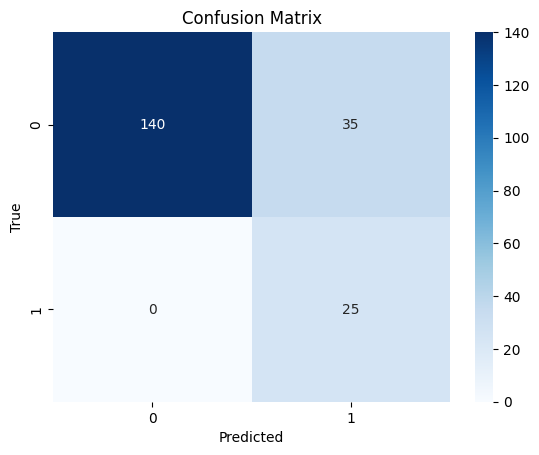

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       175
           1       0.42      1.00      0.59        25

    accuracy                           0.82       200
   macro avg       0.71      0.90      0.74       200
weighted avg       0.93      0.82      0.85       200



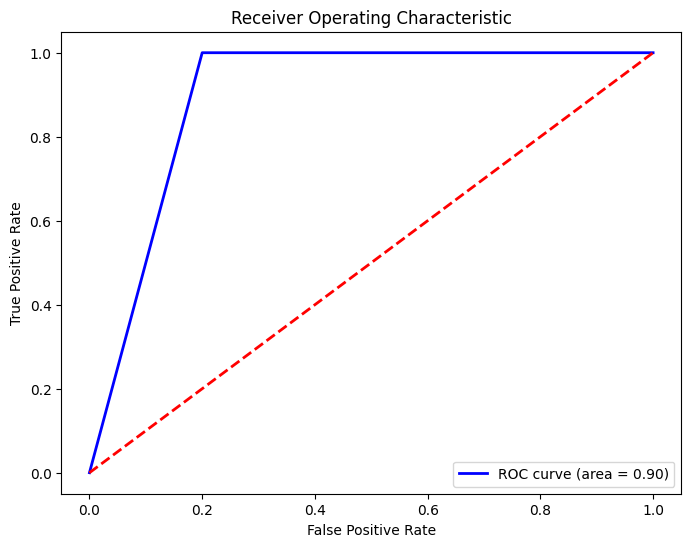

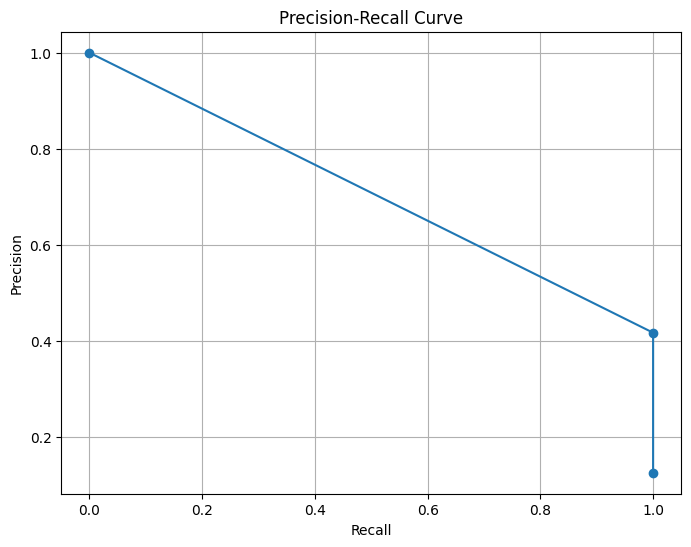

In [139]:
y_true = df["is_fraud"]
y_pred = df["predictions"]

# Evaluate with Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

# Conclusion